<a href="https://colab.research.google.com/github/gadm21/videoToSeq/blob/main/videoLabelingNewRise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
%%capture
!git clone https://github.com/gadm21/videoToSeq.git

!pip install  moviepy==1.0.3
!pip install  git+https://github.com/nficano/pytube

In [ ]:
import os
import sys
import cv2 
import pickle 
import matplotlib.pyplot as plt

import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from textblob import TextBlob, Word 
from collections import Counter

from tensorflow.keras.utils import to_categorical
from keras.callbacks import * 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
%cd videoToSeq/

parent_path = '/content/drive/MyDrive/videoLabeling'
src_path = '/content/videoToSeq/src'
sys.path.append(src_path)

drive_videos_path = os.path.join(parent_path, 'videos') 
drive_model_path = os.path.join(parent_path, 'model') 
drive_history_path = os.path.join(parent_path, 'history')

embeddings_200_path = '/content/drive/My Drive/image_caption_project/embeddings_200.pickle'



/content/videoToSeq


In [ ]:
from utils import *
from VideoHandler import *
from vmodel import * 
from vocab import * 
from frameWork import *


# Functions

In [ ]:

def get_glove(path):
  #!wget http://nlp.stanford.edu/data/glove.6B.zip
  #!unzip glove*.zip
  with open(path, 'rb') as f :
    return pickle.load(f) 


def get_video_ids(params):

    raw_data = read_json(params['training_data'])
    captions = raw_data['sentences']
    videos = raw_data['videos']
    
    relevant_words = ['class', 'student', 'teacher', 'class']
    #relevant_words.extend(['listen', 'room', 'speak', 'tell', 'discuss', 'enter', 'leave']) 
    irrelevant_words = ['truck', 'road']
    relevant = findWholeWords(relevant_words) 
    irrelevant = findWholeWords(irrelevant_words)

    captions = [(caption['caption'], caption['video_id']) for caption in captions if searchForWord(relevant, caption['caption']) and not searchForWord(irrelevant, caption['caption'])]
    
    
    all_nouns_verbs = []
    full_captions = []
    short_captions = [] 
    videos = []
    words = []
    poss = [] 

    for caption, video_id in captions:
        tokens = tokenize_caption(caption) 
        nouns_verbs = [(Word(word).lemmatize(myPosTagger(pos)), myPosTagger(pos)) for (word, pos) in nltk.pos_tag(tokens) if pos[:2]=='NN' or pos[:2]=='VB']
        if len(nouns_verbs) != 3 or not SOV(nouns_verbs): continue 
        if video_id in videos :continue
        videos.append(video_id)
        all_nouns_verbs.append(nouns_verbs)
        for word, pos in nouns_verbs : 
          words.append((word, pos))
        
        full_captions.append(caption) 
        short_captions.append(' '.join([word[0] for word in nouns_verbs]))

    freqs = Counter(words)
    freqs = sorted(freqs.items(), key = lambda item: item[1], reverse = True) 
    
    return videos, full_captions, short_captions, freqs




def download_videos(vHandler, video_ids):

  import progressbar
  bar = progressbar.ProgressBar(maxval=len(video_ids), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start() 


  cached_videos = [] 
  videos = [vHandler.vid2cap[id][0] for id in video_ids]
  for i, video in enumerate(videos) : 
    bar.update(i) 

    video_name = video['video_id'] + '.mp4'
    if video_name in cached_videos : continue 

    result = vHandler.get_video(video, download = True) 

    if result == False :
      print("http many requests error")
      return cached_videos
    elif result == True : continue  
    else : 
      result.close() 
      cached_videos.append(video_name)
  

  bar.finish() 
  return cached_videos

def get_distance(word1, word2, glove, distance_func, silent_kill = True):
  u = glove.get(word1, None) 
  v = glove.get(word2, None) 

  if u is None or v is None : 
    if not silent_kill :  print("{} or {} dosnot exist in GloVe".format(word1, word2)) 
    return 0
  
  return distance_func(u, v)



# Draft

In [ ]:
sample_word = 'students'


In [ ]:
pos = nltk.pos_tag([sample_word])
myPosTagger(pos[0][1]) 

'n'

In [ ]:
Word(sample_word).lemmatize(myPosTagger(pos[0][1]))

'student'

# Find relevant videos

In [ ]:
params = read_yaml()

In [ ]:
video_ids, full_captions, short_captions, freqs = get_video_ids(params)

In [ ]:
print(freqs)

[(('class', 'n'), 14), (('talk', 'v'), 9), (('teacher', 'n'), 6), (('student', 'n'), 5), (('man', 'n'), 4), (('child', 'n'), 3), (('teach', 'v'), 2), (('people', 'n'), 2), (('do', 'v'), 2), (('talk', 'n'), 2), (('school', 'n'), 2), (('be', 'v'), 2), (('men', 'n'), 1), (('promote', 'v'), 1), (('hit', 'v'), 1), (('boy', 'n'), 1), (('sit', 'v'), 1), (('guy', 'n'), 1), (('take', 'v'), 1), (('discuss', 'v'), 1), (('job', 'n'), 1), (('teachers', 'v'), 1), (('day', 'n'), 1), (('play', 'v'), 1), (('instrument', 'n'), 1), (('president', 'n'), 1), (('speak', 'v'), 1), (('give', 'v'), 1), (('interview', 'n'), 1), (('woman', 'n'), 1), (('explain', 'v'), 1), (('professor', 'n'), 1), (('improve', 'v'), 1), (('education', 'n'), 1), (('girl', 'n'), 1), (('animation', 'n'), 1), (('camera', 'n'), 1)]


# Download classroom videos

In [ ]:
vHandler = VideoHandler(params) 
vHandler.vids_dir = drive_videos_path 
cached_videos = download_videos(vHandler, video_ids)

[========================================================================] 100%


In [ ]:
len(video_ids), len(cached_videos), len(os.listdir(vHandler.vids_dir))

(26, 24, 24)

# Inspect video captions

In [ ]:
vHandler = VideoHandler(params) 
vHandler.vids_dir = drive_videos_path 
for id in video_ids : 
  print("id:", id)

  video_details = vHandler.vid2cap[id] 
  for caption in video_details[1:] :
    print(caption)

  print()

id: video24
a  man is driving a car
a clip with a heavy man talking to the camera
an advertisement of software
an introduction for a how to use linux tutorial
guys showcasing technology for people
people are hosting show
the beginning of a tech show
the site was very informative
the video is a trailer for some tv show
there is a man who met another man in this video and he is also travelling in a car
two man s are talking to each other about something
two men and standing beside each other
two men are talking
two men discuss linux options with their computers
two men promote their linux class
two men stand together and talk while opening credits to a show appear intermittendly
two men star in how to linux
two overweight men talking and one of the men drives a car
two people are talking to each other
the site was very informative

id: video267
3d characters play on the playground
a cartoon mother is speaking to cartoon children
a children s cartoon where a woman teaches the kids somethi

# GloVe

In [ ]:

glove = get_glove(embeddings_200_path) 

In [ ]:

nouns, verbs = [], []
verbs_gloves, nouns_gloves = [], []
for word in freqs :
  if word[0][1] == 'v':
    verbs.append((word[0][0], word[1]))
    verbs_gloves.append(glove.get(word[0][0], np.zeros((200))))
  else:
    nouns.append((word[0][0], word[1]))
    nouns_gloves.append(glove.get(word[0][0], np.zeros((200)))) 
verbs_gloves = np.array(verbs_gloves) 
nouns_gloves = np.array(nouns_gloves)

verbs_gloves.shape, nouns_gloves.shape

((15, 200), (22, 200))

In [ ]:
verbs[0]

('talk', 9)

# 2D Plot

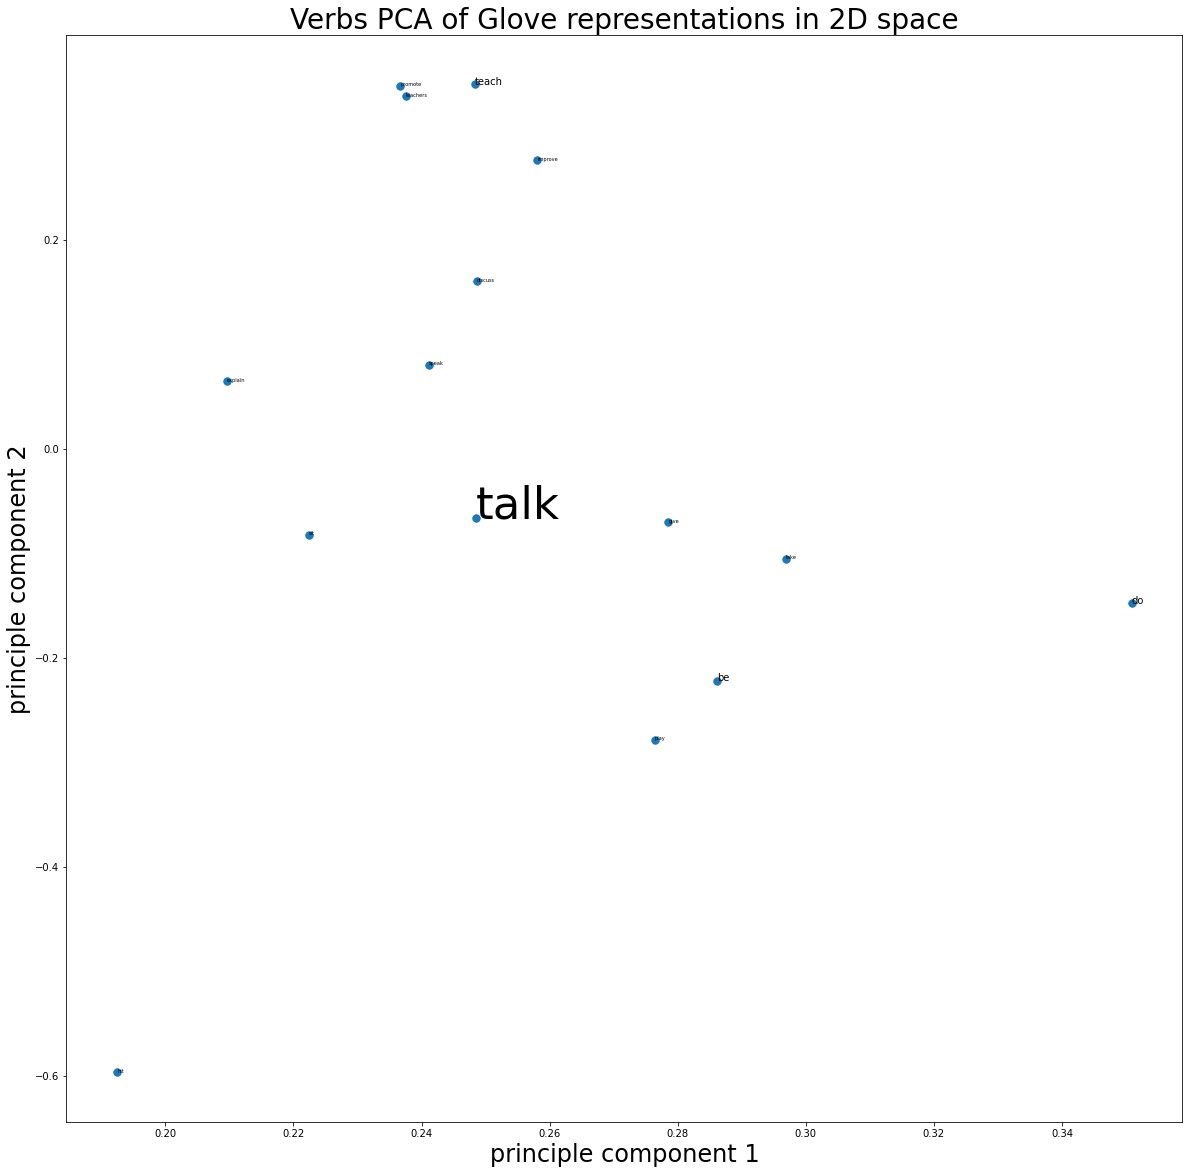

In [ ]:


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(verbs_gloves.transpose()) 
pca.components_.shape

import matplotlib.pyplot as plt

xdata = pca.components_[0, :]
ydata = pca.components_[1, :]
#zdata = pca.components_[2, :]

#xdata = np.log(xdata) 
#ydata = np.log(ydata)
#zdata = np.log(zdata) 

fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
ax.scatter(xdata, ydata, s = 55, cmap='Greens');

plt.title("Verbs PCA of Glove representations in 2D space", fontsize= 28)
plt.xlabel("principle component 1", fontsize = 24)
plt.ylabel("principle component 2", fontsize = 24)

for i, (word, freq) in enumerate(verbs):
  ax.annotate(word, (xdata[i], ydata[i]), size = min(50, freq*5))

plt.show()

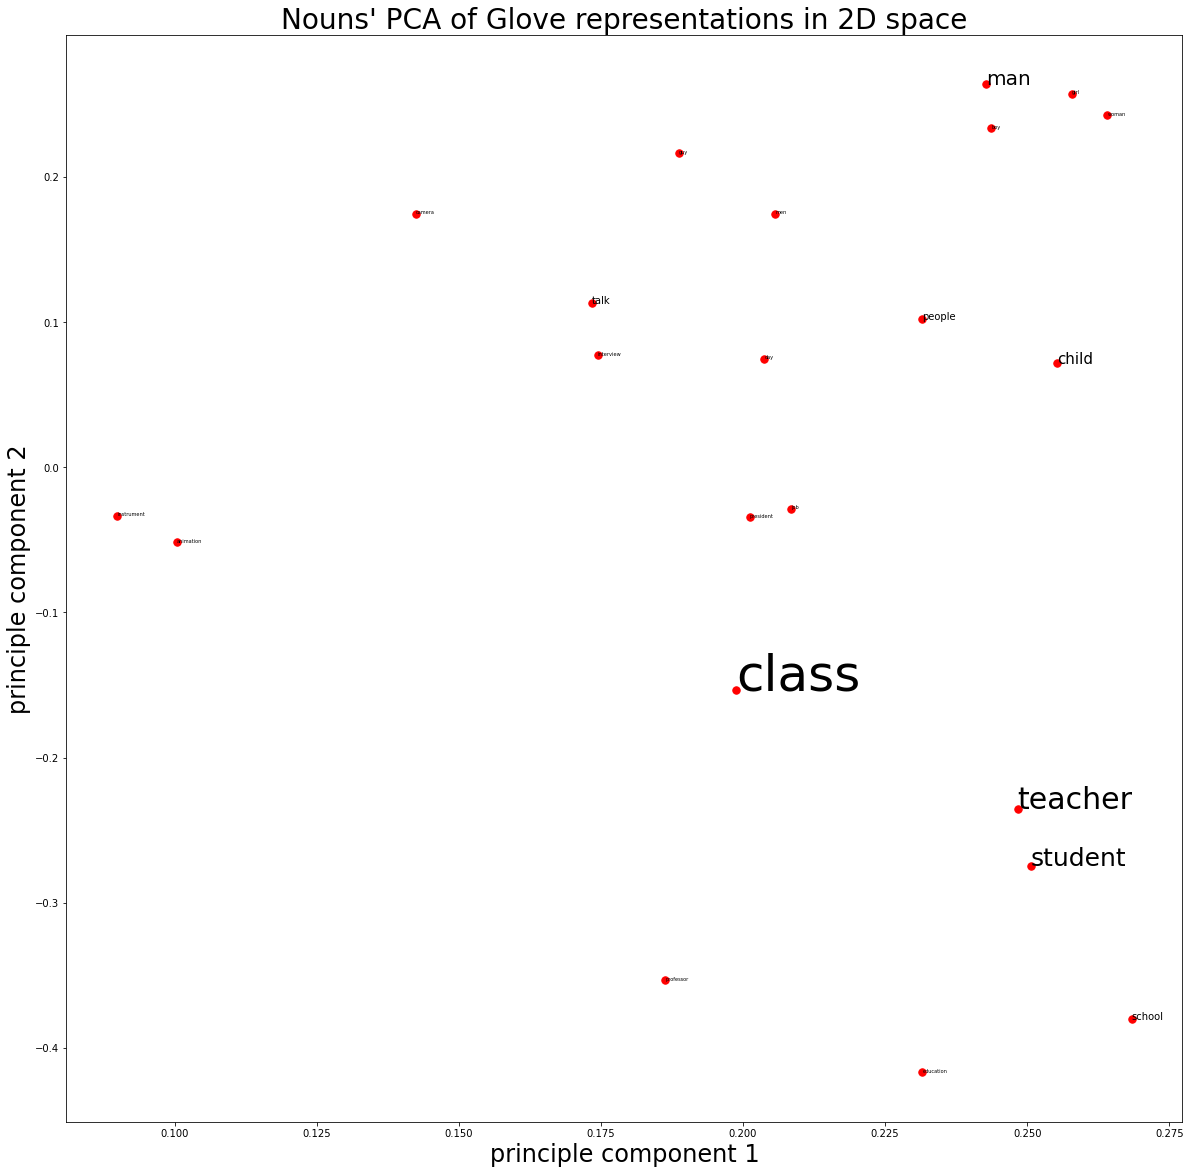

In [ ]:


from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(nouns_gloves.transpose()) 
pca.components_.shape

import matplotlib.pyplot as plt

xdata = pca.components_[0, :]
ydata = pca.components_[1, :]
#zdata = pca.components_[2, :]

#xdata = np.log(xdata) 
#ydata = np.log(ydata)
#zdata = np.log(zdata) 

fig = plt.figure(figsize = (20, 20))
ax = plt.axes()
ax.scatter(xdata, ydata, s = 55, color='red');

plt.title("Nouns' PCA of Glove representations in 2D space", fontsize= 28)
plt.xlabel("principle component 1", fontsize = 24)
plt.ylabel("principle component 2", fontsize = 24)

for i, (word, freq) in enumerate(nouns):
  ax.annotate(word, (xdata[i], ydata[i]), size = min(50, freq*5))

plt.show()

# 3D Plot

In [ ]:

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(nouns_gloves.transpose()) 
pca.components_.shape

(3, 22)

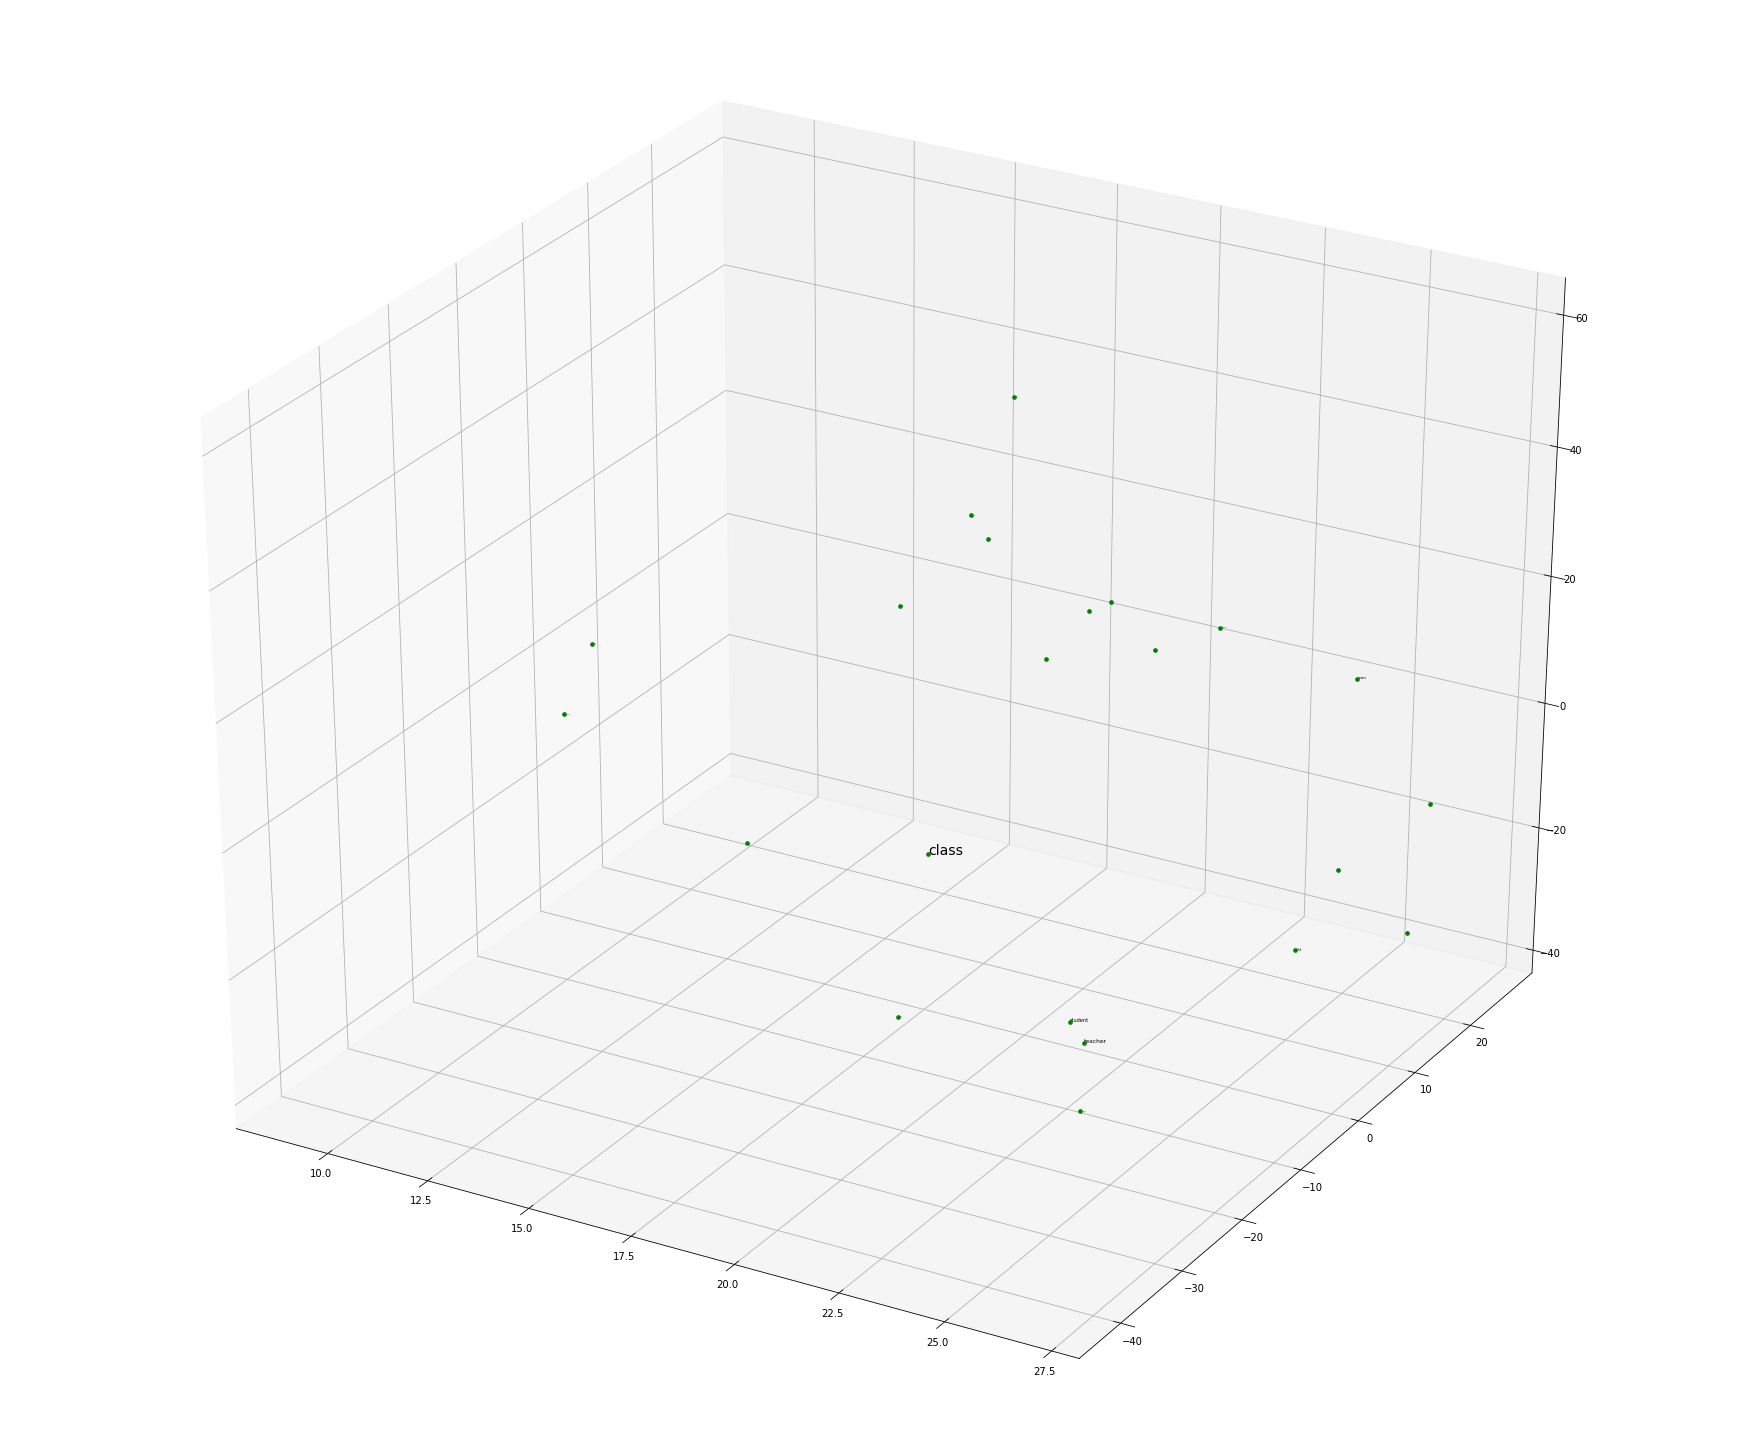

In [ ]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import rand
from pylab import figure
xdata = pca.components_[0, :]
ydata = pca.components_[1, :]
zdata = pca.components_[2, :]


fig = figure(figsize = (24,20))
ax = Axes3D(fig)

#norm_freqs = freqss / np.linalg.norm(freqss)


for i, (word, freq) in enumerate(nouns) :
  ax.scatter(xdata[i]*100, ydata[i]*100, zdata[i]*100, s = 13, color = 'green')
  ax.text(xdata[i]*100, ydata[i]*100, zdata[i]*100, "%s" % (word), size=min(17, freq))# size = min(20, norm_freqs[i]*100))

plt.show()


# Distances

In [ ]:
from scipy.spatial import distance

plain_verbs = [verb[0] for verb in verbs] 
plain_nouns = [noun[0] for noun in nouns]

verbs_freqs = {verb:freq for (verb, freq) in verbs} 
nouns_freqs = {noun:freq for (noun, freq) in nouns} 

In [ ]:

reference = 'bring'

distances = [get_distance(reference, word, glove, distance.euclidean, silent_kill=True) for word in plain_verbs]
distances = np.array(distances)

threshold = distances.mean() - (distances.std()*1.6)
idx = np.where((distances < threshold) & ( distances != 0))
close_words = [plain_verbs[index] for index in idx[0]]
close_words.append(reference) 

for word in close_words : 
  print(word, ' ', verbs_freqs[word])

come   7
bring   2


In [ ]:

reference = 'office'

distances = [get_distance(reference, word, glove, distance.euclidean, silent_kill=True) for word in plain_nouns]
distances = np.array(distances)

threshold = distances.mean() - (distances.std()*1.2)
idx = np.where((distances < threshold) & ( distances != 0))
close_words = [plain_nouns[index] for index in idx[0]]
close_words.append(reference) 

for word in close_words : 
  if word in nouns_freqs:
    pass
  print(word, ' ', nouns_freqs[word])

house   7
official   1
office   4


In [ ]:
verbs_freqs_sorted = sorted(verbs_freqs.items(), key = lambda x : x[1]) 
verbs_freqs_sorted

# Leaving !

In [ ]:
for id, caption in zip(video_ids, short_captions):
  print(id, ' ', caption)

video24   men promote class
video267   child talk teacher
video6415   man teach class
video9880   teacher hit student
video1882   boy talk teacher
video3571   man talk student
video2752   student sit class
video176   guy take class
video7202   people do class
video4434   man discuss class
video1781   teacher talk job
video5311   talk teachers child
video2392   school talk day
video1820   student play instrument
video676   president speak class
video236   teacher give interview
video2262   woman explain class
video8331   professor teach class
video9560   student be class
video9908   talk improve education
video231   girl be class
video4349   child talk teacher
video9769   people do class
video6188   animation talk class
video4382   school talk camera
video8133   man talk class


In [ ]:
!zip -r videos.zip '/content/drive/MyDrive/videoLabeling/videos'

  adding: content/drive/MyDrive/videoLabeling/videos/ (stored 0%)
  adding: content/drive/MyDrive/videoLabeling/videos/video24.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video6415.mp4 (deflated 4%)
  adding: content/drive/MyDrive/videoLabeling/videos/video9880.mp4 (deflated 2%)
  adding: content/drive/MyDrive/videoLabeling/videos/video1882.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video2752.mp4 (deflated 2%)
  adding: content/drive/MyDrive/videoLabeling/videos/video176.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video7202.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video4434.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video1781.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video5311.mp4 (deflated 1%)
  adding: content/drive/MyDrive/videoLabeling/videos/video2392.mp4 (deflated 12%)
  adding: content/drive/MyDrive/videoLabeling

In [ ]:
!dir

7agaty.yaml  innocent_data  README.md	      train_2017
data	     logs	    requirements.txt  videos.zip
draft	     __pycache__    src		      visuals
